In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Introductory setup from previous 2 parts

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
sns.set(rc = {'figure.figsize':(11.7,8.27)})
cars_data = pd.read_csv("cars_sampled.csv")
cars = cars_data.copy()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' %x)
pd.set_option('display.max_columns', 500)
cars.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,postalCode
count,50001.000,50001.000,50001.000,50001.000,50001.000,50001.000
mean,6559.865,2005.544,116.496,125613.688,5.744,50775.217
std,85818.470,122.992,230.568,40205.234,3.711,25743.702
min,0.000,1000.000,0.000,5000.000,0.000,1067.000
25%,1150.000,1999.000,69.000,125000.000,3.000,30559.000
50%,2950.000,2003.000,105.000,150000.000,6.000,49504.000
75%,7190.000,2008.000,150.000,150000.000,9.000,71404.000
max,12345678.000,9999.000,19312.000,150000.000,12.000,99998.000


In [ ]:
col = ['name','dateCrawled','dateCreated','postalCode','lastSeen']
cars = cars.drop(columns = col, axis= 1)

cars.drop_duplicates(keep = 'first', inplace = True)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49531 entries, 0 to 50000
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   seller               49531 non-null  object
 1   offerType            49531 non-null  object
 2   price                49531 non-null  int64 
 3   abtest               49531 non-null  object
 4   vehicleType          44379 non-null  object
 5   yearOfRegistration   49531 non-null  int64 
 6   gearbox              46766 non-null  object
 7   powerPS              49531 non-null  int64 
 8   model                46801 non-null  object
 9   kilometer            49531 non-null  int64 
 10  monthOfRegistration  49531 non-null  int64 
 11  fuelType             45064 non-null  object
 12  brand                49531 non-null  object
 13  notRepairedDamage    39891 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.7+ MB


In [ ]:
cars = cars[
    (cars["yearOfRegistration"] <= 2018)
    &(cars["yearOfRegistration"] >= 1950)
    &(cars["price"] >= 100)
    &(cars["price"] <= 150000)
    &(cars["powerPS"] >= 10)
    &(cars["powerPS"] <= 500)
]
# Approx 6700 records are dropped

In [ ]:
cars['Age'] = (2018 - cars['yearOfRegistration']) + ((cars['monthOfRegistration'])/12)
cars["Age"] = round(cars["Age"], 2)
cars['Age'].describe()

count   42772.000
mean       14.873
std         7.093
min         0.000
25%        10.330
50%        14.830
75%        19.170
max        67.750
Name: Age, dtype: float64

In [ ]:
cars = cars.drop(columns = ['yearOfRegistration','monthOfRegistration'])

In [ ]:
cols = ['seller', 'offerType', 'abtest']
cars = cars.drop(columns = cols, axis = 1)
cars_copy = cars.copy()

In [ ]:
cars_select1 = cars.select_dtypes(exclude = [object])
correlation = cars_select1.corr()
print(round(correlation,3))
print(cars_select1.corr().loc[:,'price'].abs().sort_values(ascending  = False))

           price  powerPS  kilometer    Age
price      1.000    0.575     -0.440 -0.336
powerPS    0.575    1.000     -0.016 -0.151
kilometer -0.440   -0.016      1.000  0.292
Age       -0.336   -0.151      0.292  1.000
price       1.000
powerPS     0.575
kilometer   0.440
Age         0.336
Name: price, dtype: float64


## Actual code of this Session
We are going to build a linear regression and random forest regression model on 2 sets of data
1. Data obtained by omitting rows with any missing value
2. Data obtained by imputing the misssing values

## ==== Omitting the missing values ====

In [ ]:
cars_omit = cars.dropna(axis = 0)
# Approx 10000 records removed

#### converting categorical variables into dummy variables

In [ ]:
cars_omit = pd.get_dummies(cars_omit, drop_first = True)

#### importing necessary libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
help()


Welcome to Python 3.8's help utility!

If this is your first time using Python, you should definitely check out
the tutorial on the Internet at https://docs.python.org/3.8/tutorial/.

Enter the name of any module, keyword, or topic to get help on writing
Python programs and using Python modules.  To quit this help utility and
return to the interpreter, just type "quit".

To get a list of available modules, keywords, symbols, or topics, type
"modules", "keywords", "symbols", or "topics".  Each module also comes
with a one-line summary of what it does; to list the modules whose name
or summary contain a given string such as "spam", type "modules spam".

help> exit()
No Python documentation found for 'exit()'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

help> quit

You are now leaving help and returning to the Python interpreter.
If you want to ask for help on a particular object directly from the
interpreter, you can type "help(object)".  Ex

### ===== Building model with the omitted data =====
#### separating input and output variables

In [ ]:
x1 = cars_omit.drop(['price'], axis= 1, inplace = False)
y1 = cars_omit['price']

#### plotting the variable price

array([[<AxesSubplot:title={'center':'1. Before'}>,
        <AxesSubplot:title={'center':'2. After'}>]], dtype=object)

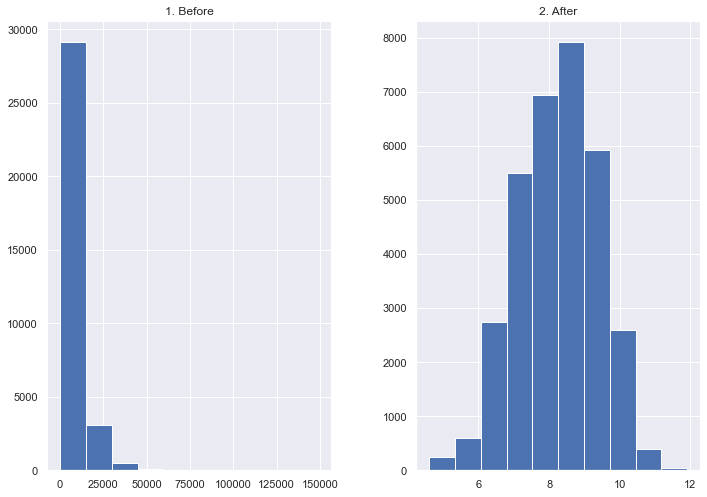

In [ ]:
prices = pd.DataFrame({"1. Before": y1, "2. After": np.log(y1)})
prices.hist()

1. for histogram for log(prices)... it is nicely bell shaped
2. for histogram for simply prices... it is a skewed graph

so it is better to go further with natural log of prices and not just with price

So, we will be regressing the natural logarithm of prices with the input features

#### Transforming price as a Logarthmic value

In [ ]:
y1 = np.log(y1)

#### Splitting the data into test and train

In [ ]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(x1, y1, test_size = 0.3, random_state = 3)
print(X_train1.shape, X_test1.shape, Y_train1.shape, Y_test1.shape)

(23018, 300) (9866, 300) (23018,) (9866,)


### Baseline Model for the Omitted Data
In baseline model the predicted value is replaced by the mean value of the test data

We are making a base model by using test data mean value

This is to set a benchmark and to compare with our regression model

inshort... setting the base value (base metric)

#### finding mean for test data value

In [ ]:
base_pred_1 = np.mean(Y_test1)
print(base_pred_1)

8.249615787653337


#### Repeating the same value till the length of test data

In [ ]:
base_pred_1 = np.repeat(base_pred_1, len(Y_test1))

#### Finding RMSE (Root Mean Square Error)
1. it computes the difference between test value and predicted value .... squares them... and divides by the no. of observations
2. this is the mean squared error
3. when you take the squareroot of mean squared error... you get RMSE value

In [ ]:
base_root_mean_square_error_1 = np.sqrt(mean_squared_error(Y_test1, base_pred_1))
print(base_root_mean_square_error_1)

1.1274483657478247


## Linear Regression with Omitted Data

#### Setting intercept as true

In [ ]:
lgr = LinearRegression(fit_intercept = True)

#### model

In [ ]:
model_lin1 = lgr.fit(X_train1, Y_train1)

#### Predicting model on test set

In [ ]:
cars_predictions_lin1 = lgr.predict(X_test1)

#### calculating MSE and RMSE for predictions

In [ ]:
lin_mse1 = mean_squared_error(Y_test1, cars_predictions_lin1)
lin_rmse1 = np.sqrt(lin_mse1)
print(lin_rmse1)

0.5455481266513822


it should be noted that the RMSE valus has dropped from 1.12 to 0.54 (Approx 50% reduction)

#### R squared value
it helps to tell you how good is your model able to explain the variability in 'Y'

In [ ]:
r2_lin_train1 = model_lin1.score(X_train1, Y_train1)
r2_lin_test1 = model_lin1.score(X_test1, Y_test1)
print(f"r2_lin1_train1: {r2_lin_train1}\nr2_lin1_test1: {r2_lin_test1}")

r2_lin1_train1: 0.7800936978183916
r2_lin1_test1: 0.7658615091649259


R sq. value for train set is 0.78 and R sq. value for test set is 0.765

cutting quite close... train set is definitely better... but the test set is not far behind

This tells that our model is good

As much as variability the model was able to capture in the train data...it is able to capture the same amount of variability (if not more) in the test data as well.

#### Regression diagnostics: Residual Plot analysis
Residual: difference between predicted value (cars_predictions_lin1) and actual value (Y_test)

Residual = Actual - Predicted

<AxesSubplot:ylabel='price'>

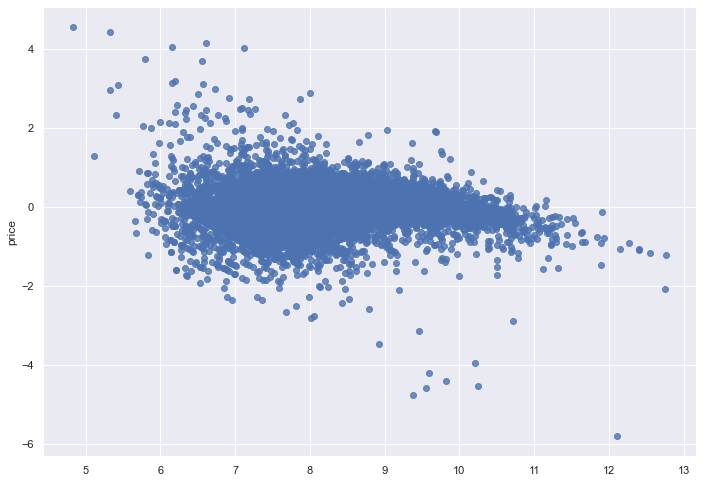

In [ ]:
residuals = Y_test1 - cars_predictions_lin1
sns.regplot(x = cars_predictions_lin1, y= residuals, scatter = True, fit_reg= False)

In [ ]:
residuals.describe()

count   9866.000
mean       0.003
std        0.546
min       -5.796
25%       -0.261
50%        0.041
75%        0.302
max        4.547
Name: price, dtype: float64

## Random Forest regressor using omitted data
### Parameters


#### n_estimators: 'int' (def 100)
Number of trees in the forest
#### min_samples_split: 'int' or 'float' (def 2)
Minimum No. of samples required to split an internal node
#### min_samples_leaf: int or float (def 1)
Minimum No. of samples required to be at a leaf node. A split point will be considered only if it leaves at least (Min_samples_leaf) training samples in each of left and right branches

#### max_features: {'auto', 'sqrt', 'log'}, int, float  (def 'auto')
No. of features to be considered to build the model
1. if 'auto', then max_features = n_features (chooses the features automatically)
2. if 'sqrt', then max_features = sqrt(n_features)
3. if 'log', then max_features = log(n_features)
4. if int, then consider (int) features at each split

#### max_depth: int (def None)
The maximum depth of the tree. If None, nodes are expanded untill all leaves are pure or until all leaves contain less than min_samples_split

#### criterion: {'mse', 'mae'} (def: 'mse')
#### random_state: int
it is a predefined algorithm for randomizer.... if not specified, it will take different data sets everytime

In [ ]:
rf = RandomForestRegressor(n_estimators = 100,
                          max_features = 'auto',
                          max_depth = 100,
                          min_samples_split = 10,
                          min_samples_leaf = 4,
                          random_state = 1)

#### model

In [ ]:
model_rf1 = rf.fit(X_train1, Y_train1)

In [ ]:
type(X_train1),type(X_test1), type(Y_train1), type(Y_test1)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

#### Predicting model on test set

In [ ]:
cars_predictions_rf1 = rf.predict(X_test1)

#### Computing MSE and RMSE values

In [ ]:
rf_mse1 = mean_squared_error(Y_test1, cars_predictions_rf1)
rf_rmse1 = np.sqrt(rf_mse1)
print(rf_rmse1)

0.4360736289370223


Thus, it should be noted that Random Forest model is performing better than the Linear regression model as the RMSE model has come down further

#### R squared value

In [ ]:
r2_rf_train1 = model_rf1.score(X_train1, Y_train1)
r2_rf_test1 = model_rf1.score(X_test1, Y_test1)
print(f"r2_rf_train1: {r2_rf_train1}\nr2_lin1_test1: {r2_rf_test1}")

r2_rf_train1: 0.9202494705146291
r2_lin1_test1: 0.8504018147750623


#### Thus it should be noted that the random forest model is working better than linear regression model for the omitted data

#### Attributes of Random forest
1. feature_importances_ (ndarray of shape (n_features,)): The impurity-based feature importances.
Gives the % importance given to each column
2. n_features_in_ (int): Number of features seen during fit.
3. oob_score_ (float): Score of the training dataset obtained using an out-of-bag estimate. This attribute exists only when oob_score is True

# ===== Model building with imputed data =====

1. for Numerical variable, filling na values with median
2. for categorical variable, filling na values with modal value

In [ ]:
cars_imputed = cars.apply(lambda x: x.fillna(x.median())
                         if (x.dtype == 'float' or x.dtype == 'int')
                         else x.fillna(x.value_counts().index[0]))

In [ ]:
cars_imputed.isna().sum()

price                0
vehicleType          0
gearbox              0
powerPS              0
model                0
kilometer            0
fuelType             0
brand                0
notRepairedDamage    0
Age                  0
dtype: int64

#### converting categorical variables into dummy variables

In [ ]:
cars_imputed = pd.get_dummies(cars_imputed, drop_first = True)

#### separating input and output variables

In [ ]:
x2 = cars_imputed.drop(['price'], axis= 1, inplace = False)
y2 = cars_imputed['price']

#### plotting the variable price


array([[<AxesSubplot:title={'center':'1. Before'}>,
        <AxesSubplot:title={'center':'2. After'}>]], dtype=object)

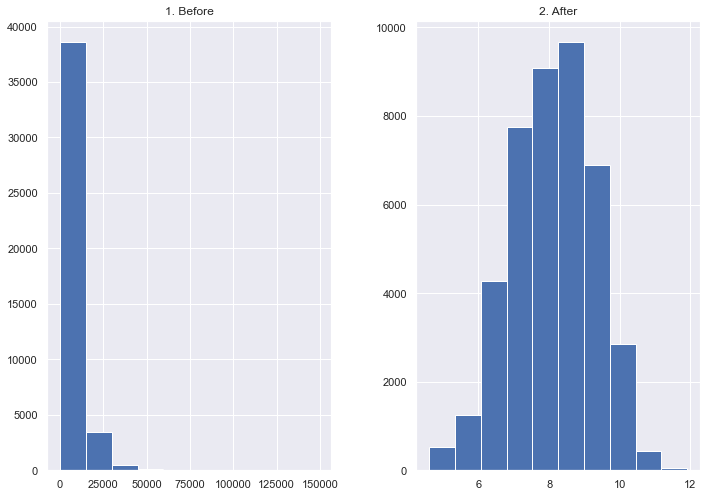

In [ ]:
prices = pd.DataFrame({"1. Before": y2, "2. After": np.log(y2)})
prices.hist()

#### Transforming price as a Logarthmic value




In [ ]:
y2 = np.log(y2)

#### Splitting the data into test and train

In [ ]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(x2, y2, test_size = 0.3, random_state = 3)
print(X_train2.shape, X_test2.shape, Y_train2.shape, Y_test2.shape)

(29940, 303) (12832, 303) (29940,) (12832,)


#### finding mean for test data value


In [ ]:
base_pred_2 = np.mean(Y_test)
print(base_pred_2)

8.068391740519193


#### Repeating the same value till the length of test data

In [ ]:
base_pred_2 = np.repeat(base_pred_2, len(Y_test2))

### Baseline Model for the imputed Data
#### Finding RMSE (Root Mean Square Error)

In [ ]:
base_root_mean_square_error_2 = np.sqrt(mean_squared_error(Y_test2, base_pred_2))
print(base_root_mean_square_error_2)

1.1884349112889792


## Linear Regression with Imputed Data
#### Setting intercept as true

In [ ]:
lgr = LinearRegression(fit_intercept = True)

#### model




In [ ]:
model_lin2 = lgr.fit(X_train2, Y_train2)

#### Predicting model on test set

In [ ]:
cars_predictions_lin2 = lgr.predict(X_test2)

#### calculating MSE and RMSE for predictions


In [ ]:
lin_mse2 = mean_squared_error(Y_test2, cars_predictions_lin2)
lin_rmse2 = np.sqrt(lin_mse2)
print(lin_rmse2)

0.6483956449231303


So after imputing the data, the error has gone slightly up (from 0.5455 to 0.6483).... obviously, because we are imputing data which was not originally present

#### R squared value



In [ ]:
r2_lin_train2 = model_lin2.score(X_train2, Y_train2)
r2_lin_test2 = model_lin2.score(X_test2, Y_test)
print(f"r2_lin1_train2: {r2_lin_train2}\nr2_lin1_test2: {r2_lin_test2}")

r2_lin1_train2: 0.7071658736894363
r2_lin1_test2: 0.7023339008631179


## Random Forest regressor using imputed data

In [ ]:
rf2 = RandomForestRegressor(n_estimators = 100,
                          max_features = 'auto',
                          max_depth = 100,
                          min_samples_split = 10,
                          min_samples_leaf = 4,
                          random_state = 1)

#### model






In [ ]:
model_rf2 = rf2.fit(X_train2, Y_train2)

#### Predicting model on test set

In [ ]:
cars_predictions_rf2 = rf2.predict(X_test2)

#### Computing MSE and RMSE values

In [ ]:
rf_mse2 = mean_squared_error(Y_test2, cars_predictions_rf2)
rf_rmse2 = np.sqrt(rf_mse2)
print(rf_rmse2)

0.494313994408829


A lot less than the RMSE value given by linear regression model (for imputed data)

#### R squared value



In [ ]:
r2_rf_train2 = model_rf2.score(X_train2, Y_train2)
r2_rf_test2 = model_rf2.score(X_test2, Y_test2)
print(f"r2_rf_train2: {r2_rf_train2}\nr2_lin1_test1: {r2_rf_test2}")

r2_rf_train2: 0.9024289431669166
r2_lin1_test1: 0.8269964521311131


#### For Imputed Data, RMSE value and R squared value drops (relative to omitted data) as we are imputing certain values that are not originally present

# FINAL OUTPUT

In [ ]:
# FOR OMITTED DATA
print(f"Metrics for models built from data where missing values were omitted")
print(f"Base RMSE value = {base_root_mean_square_error_1}")
print(f"RMSE value for linear Regression model = {lin_rmse1}")
print(f"RMSE value for Random Forest model = {rf_rmse1}")
print(f"R squared value for train from linear regression = {r2_lin_train1}")
print(f"R squared value for test from linear regression = {r2_lin_test1}")
print(f"R squared value for train from random forest regressor = {r2_rf_train1}")
print(f"R squared value for test from random forest regressor = {r2_rf_test1}")

print("\n\n")
# FOR IMPUTED DATA
print(f"Metrics for models built from data where missing values were imputed")
print(f"Base RMSE value = {base_root_mean_square_error_2}")
print(f"RMSE value for linear Regression model = {lin_rmse2}")
print(f"RMSE value for Random Forest model = {rf_rmse2}")
print(f"R squared value for train from linear regression = {r2_lin_train2}")
print(f"R squared value for test from linear regression = {r2_lin_test2}")
print(f"R squared value for train from random forest regressor = {r2_rf_train2}")
print(f"R squared value for test from random forest regressor = {r2_rf_test2}")

Metrics for models built from data where missing values were omitted
Base RMSE value = 1.1274483657478247
RMSE value for linear Regression model = 0.5455481266513822
RMSE value for Random Forest model = 0.4360736289370223
R squared value for train from linear regression = 0.7800936978183916
R squared value for test from linear regression = 0.7658615091649259
R squared value for train from random forest regressor = 0.9202494705146291
R squared value for test from random forest regressor = 0.8504018147750623



Metrics for models built from data where missing values were imputed
Base RMSE value = 1.1884349112889792
RMSE value for linear Regression model = 0.6483956449231303
RMSE value for Random Forest model = 0.494313994408829
R squared value for train from linear regression = 0.7071658736894363
R squared value for test from linear regression = 0.7023339008631179
R squared value for train from random forest regressor = 0.9024289431669166
R squared value for test from random forest regre

#### ovrall (omitted and imputed data inclusive)... Random Forest model is better than linear regression model